# Classification Supervisée de Strates

---
**IBRES Maxime - M2 SIGMA** | Série temporelle : **Bretagne 24-25** |  Date de rendue : **30 Janvier 2026**

---

# DIAGRAMME DE FLUX GLOBAL 

![digramme_flux_projet_telea_IBRES](/home/onyxia/work/projet_telea_IBRES/img/projet_telea_IBRES_Maxime.png "Diagramme de flux global")

> *N'hésitez pas à ouvrir l'image directement pour mieux voir l'intérieur !*

# 1. Configuration de l'environnement

## 1.1 -- Importation des modules utiles au code

In [1]:
# 1. RECHARGEMENT AUTOMATIQUE DES MODULES
%load_ext autoreload
%autoreload 2

# 2. IMPORTATIONS STANDARD & SYSTÈME
import os
import sys
import time

# Ajout du chemin parent pour trouver les librairies locales
sys.path.append("..")

# 3. LIBRAIRIES SCIENTIFIQUES & GÉOSPATIALES
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# 4. MACHINE LEARNING (SCIKIT-LEARN)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 5. LIBRAIRIES PERSONNELLES
from libsigma import read_and_write as rw
from libsigma import plot_confusion_matrix as pcm
from libsigma import plots
# Fonctions spécifiques à ce projet
import my_function as mf

## 1.2 -- Définition des chemins en entrée et sortie

### ➥ Dossier de travail

In [2]:
dir_path = "/home/onyxia/work"

### ➥ Chemins relatifs aux données en entrée

In [3]:
# Dossier des données
data_path = os.path.join(dir_path, "data/projet_eval")

# Les échantillons de photointerprétation
shp_path = os.path.join(data_path, "PI_strates_bretagne_32630.shp")

# Les série temporelle d’images Sentinel-2
path_B02 = os.path.join(data_path, "bretagne_24-25_B02.tif")
path_B03 = os.path.join(data_path, "bretagne_24-25_B03.tif")
path_B04 = os.path.join(data_path, "bretagne_24-25_B04.tif")
path_B05 = os.path.join(data_path, "bretagne_24-25_B05.tif")
path_B08 = os.path.join(data_path, "bretagne_24-25_B08.tif")
path_B8A = os.path.join(data_path, "bretagne_24-25_B8A.tif")
path_B11 = os.path.join(data_path, "bretagne_24-25_B11.tif")
path_B12 = os.path.join(data_path, "bretagne_24-25_B12.tif")

### ➥ Chemins relatifs aux résultats en sortie (Figures + Cartes)

In [4]:
# Dossier des cartes
result_path = os.path.join(dir_path, "results")
os.makedirs(result_path, exist_ok=True)

# Chemin des cartes
path_output_nari = os.path.join(result_path, 'ARI_serie_temp.tif')
output_map_path = os.path.join(result_path, 'carte_strates.tif')

# Dossier des figures
figure_path = os.path.join(result_path, "figure")
os.makedirs(figure_path, exist_ok=True)

# Chemins des figures
diag_nb_poly_path = os.path.join(figure_path, "diag_baton_nb_poly_by_class.png")
diag_nb_pix_path = os.path.join(figure_path, "diag_baton_nb_pix_by_class.png")
path_output_nari_series = os.path.join(figure_path, "ARI_series.png")
path_matrix = os.path.join(figure_path, "matrice_confusion.png")
path_quality = os.path.join(figure_path, "qualite_by_class.png")

## 1.3 -- Définition des données de travail

### ➥ Nomenclatures des strates et couleurs associées

In [5]:
CLASSES_INFO = {
    1: {'label': 'Sol Nu', 'color': 'lightgray'},
    2: {'label': 'Herbe', 'color': 'yellowgreen'},
    3: {'label': 'Landes', 'color': 'sandybrown'},
    4: {'label': 'Arbre', 'color': 'forestgreen'}
}

# Extraction automatique pour les graphes
#LABELS_LIST = [v['label'] for k, v in CLASSES_INFO.items()]
LABELS_DICT = {k: v['label'] for k, v in CLASSES_INFO.items()}
#COLORS_LIST = [v['color'] for k, v in CLASSES_INFO.items()]
NAME_TO_COLOR = {v['label']: v['color'] for k, v in CLASSES_INFO.items()}
clean_labels = ['Herbe', 'Landes', 'Arbre']

### ➥ Dates de la série temporelle

L'analyse repose sur une **série d'images Sentinel-2** acquises durant la période **2024-2025**. Les **6 dates** retenues pour cette étude sont définies ci-dessous :

In [6]:
dates_str = [
    '2025-03-31', '2025-04-10', '2025-05-15', 
    '2025-06-17', '2025-07-12', '2025-08-10'
]

## 1.4. -- Résolution du bug sur les graphiques

In [7]:
# Désactive LaTeX pour tout le reste du notebook (= PBM avec fonction de matrice de confusion)
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif'
})
print("Configuration Matplotlib réparée : LaTeX désactivé.")

Configuration Matplotlib réparée : LaTeX désactivé.


---
# 2. Exploration des échantillons

## 2.1. -- Nombre d’échantillons

### ➥ Importation des échantillons obtenues par photo interprétation

In [8]:
gdf = gpd.read_file(shp_path)
label_strates = 'strate'
print(f"Nombre total d'échantillons chargés : {len(gdf)} polygones")
display(gdf.head())

Nombre total d'échantillons chargés : 278 polygones


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


Cet extrait de la table attributaire du fichier **PI_strates_bretagne.shp** met en évidence la colonne cible `strate`. Ce champ contient les labels numériques (codes classes) qui sont associés aux descriptions textuelles définies précédemment dans le dictionnaire `CLASSES_INFO`.

 ### ➥ Calcul des métriques par strates

In [9]:
df_stats = mf.analyze_polygon_metrics(gdf, class_col='strate', labels_dict=LABELS_DICT)

### ➥ Tableau bilan & Graphiques

In [10]:
# Extraction des variables pour graphiques
serie_poly = df_stats['Nb_Polygones']
serie_pix = df_stats['Nb_Pixels']
# Préparation des couleurs
colors_poly = [NAME_TO_COLOR[label] for label in serie_poly.index]
colors_pix = [NAME_TO_COLOR[label] for label in serie_pix.index]

=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png.
=> Graphique sauvegardé dans /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png.


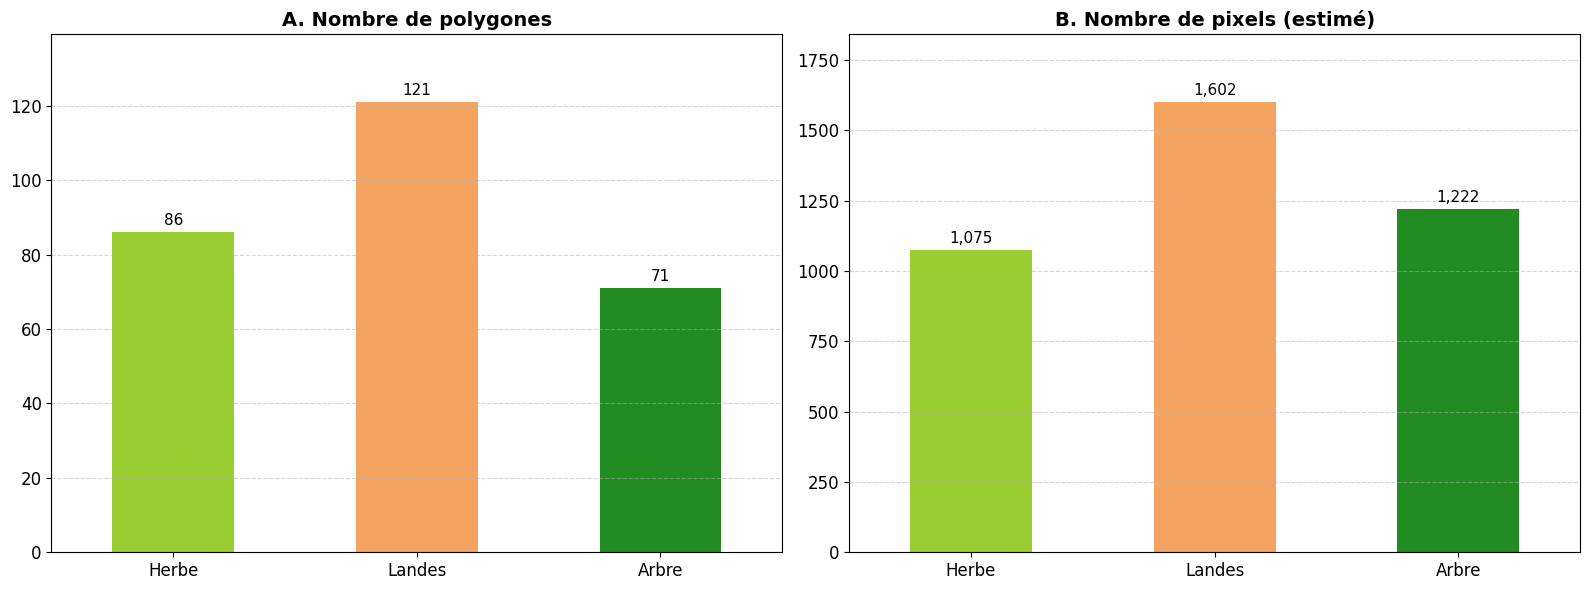


=== Bilan des Échantillons (Tableau) ===


,Nb_Polygones,% Polygones,Nb_Pixels,% Pixels,Taille Moyenne (px)
Herbe,86,30.94 %,"1,075",27.58 %,12.5
Landes,121,43.53 %,"1,602",41.08 %,13.2
Arbre,71,25.54 %,"1,222",31.34 %,17.2
TOTAL,278,100.00 %,"3,899",100.00 %,14.0


In [11]:
# Sauvegarde
mf.save_class_distributions(
    serie_poly, serie_pix, 
    colors_poly, colors_pix, 
    diag_nb_poly_path, diag_nb_pix_path
)

# Affichage visuel
mf.show_class_distributions(
    serie_poly, serie_pix, 
    colors_poly, colors_pix
)

# Affichage du Tableau Bilan
print("\n=== Bilan des Échantillons (Tableau) ===")

total_poly = serie_poly.sum()
total_pix = serie_pix.sum()
avg_global = total_pix / total_poly if total_poly > 0 else 0

row_total = pd.DataFrame({
    'Nb_Polygones': [total_poly],
    '% Polygones': [100.0],
    'Nb_Pixels': [total_pix],
    '% Pixels': [100.0],
    'Taille Moyenne (px)': [avg_global]
}, index=['TOTAL'])

df_final_display = pd.concat([df_stats, row_total])

display(df_final_display.style.format({
    'Nb_Polygones': '{:.0f}',
    'Nb_Pixels': '{:,.0f}',
    '% Polygones': '{:.2f} %',
    '% Pixels': '{:.2f} %',
    'Taille Moyenne (px)': '{:,.1f}'
}))

Le tableau bilan et le graphique associé illustrent la répartition des données de vérité terrain entre les trois classes principales :
- **Absence de la classe `Sol Nu`** : Aucun polygone n'est présent dans le fichier d'échantillons.
- **Dominance de la classe `Landes`** : C'est la mieux représentée, constituant environ 43,5% des polygones et 41% de la surface totale (en nombre de pixels).
- **Équilibre global satisfaisant** : Bien que la classe `Landes` soit majoritaire, le déséquilibre n'est pas critique. Les classes `Herbe` et `Arbre` conservent une représentation significative (respectivement ~27% et ~31% des pixels) et nous ne sommes pas dans un cas de déséquilibre total.
- **Déséquilibre taille des pixels de la classe `Arbre`** : Les polygones de la classe `Arbre` sont en moyenne 37% plus grands que ceux de la classe `Herbe`, ce qui explique pourquoi la classe `Arbre` représente 31,3% de la surface totale (pixels) alors qu'elle ne compte que 25,5% des polygones.

## 2.1 Analyse Temporelle (Phénologie des landes)
Les landes que nous cherchons à caractériser appartiennent majoritairement à la famille des **Éricacées**. Elles se distinguent physiologiquement par une forte concentration en **anthocyanes**. À l'instar de la chlorophylle, ce sont des pigments végétaux, mais de couleur rouge/violette. Ils deviennent particulièrement visibles et dominants en **automne**, offrant une signature spectrale unique par rapport aux autres strates.

Pour exploiter cette spécificité, nous calculons le **Normalized Anthocyanin Reflectance Index (NARI)**. Il utilise la bande du **Vert (B03)** et celle du **Red-Edge (B05)** de Sentinel-2 selon la formule suivante :

$$ARI = \frac{\\1/B03 - \\1/B05}{\\1/B03 + \\1/B05}$$

> *Note : Cet indice permet de maximiser la discrimination des landes par rapport à la végétation saine dominée par la chlorophylle.*

### ➥ Calcul de l'indice NARI pour chaque date

In [12]:
# Chargement
arr_b03 = rw.load_img_as_array(path_B03)
arr_b05 = rw.load_img_as_array(path_B05)

# Calcul du NARI
nari = mf.compute_nari(arr_b03, arr_b05)

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Calcul du NARI effectué.


In [13]:
# Sauvegarde
ds_ref = rw.open_image(path_B03) # Pour récupérer la projection
rw.write_image(
    out_filename=path_output_nari,
    array=nari,
    data_set=ds_ref,
    gdal_dtype=gdal.GDT_Float32,
    driver_name="GTiff"
)

# Ajout du tag NoData 
mf.add_nodata_metadata(path_output_nari, nodata_value=-9999)

print(f"=> Fichier NARI généré et tagué : {path_output_nari}")

=> Fichier NARI généré et tagué : /home/onyxia/work/results/ARI_serie_temp.tif


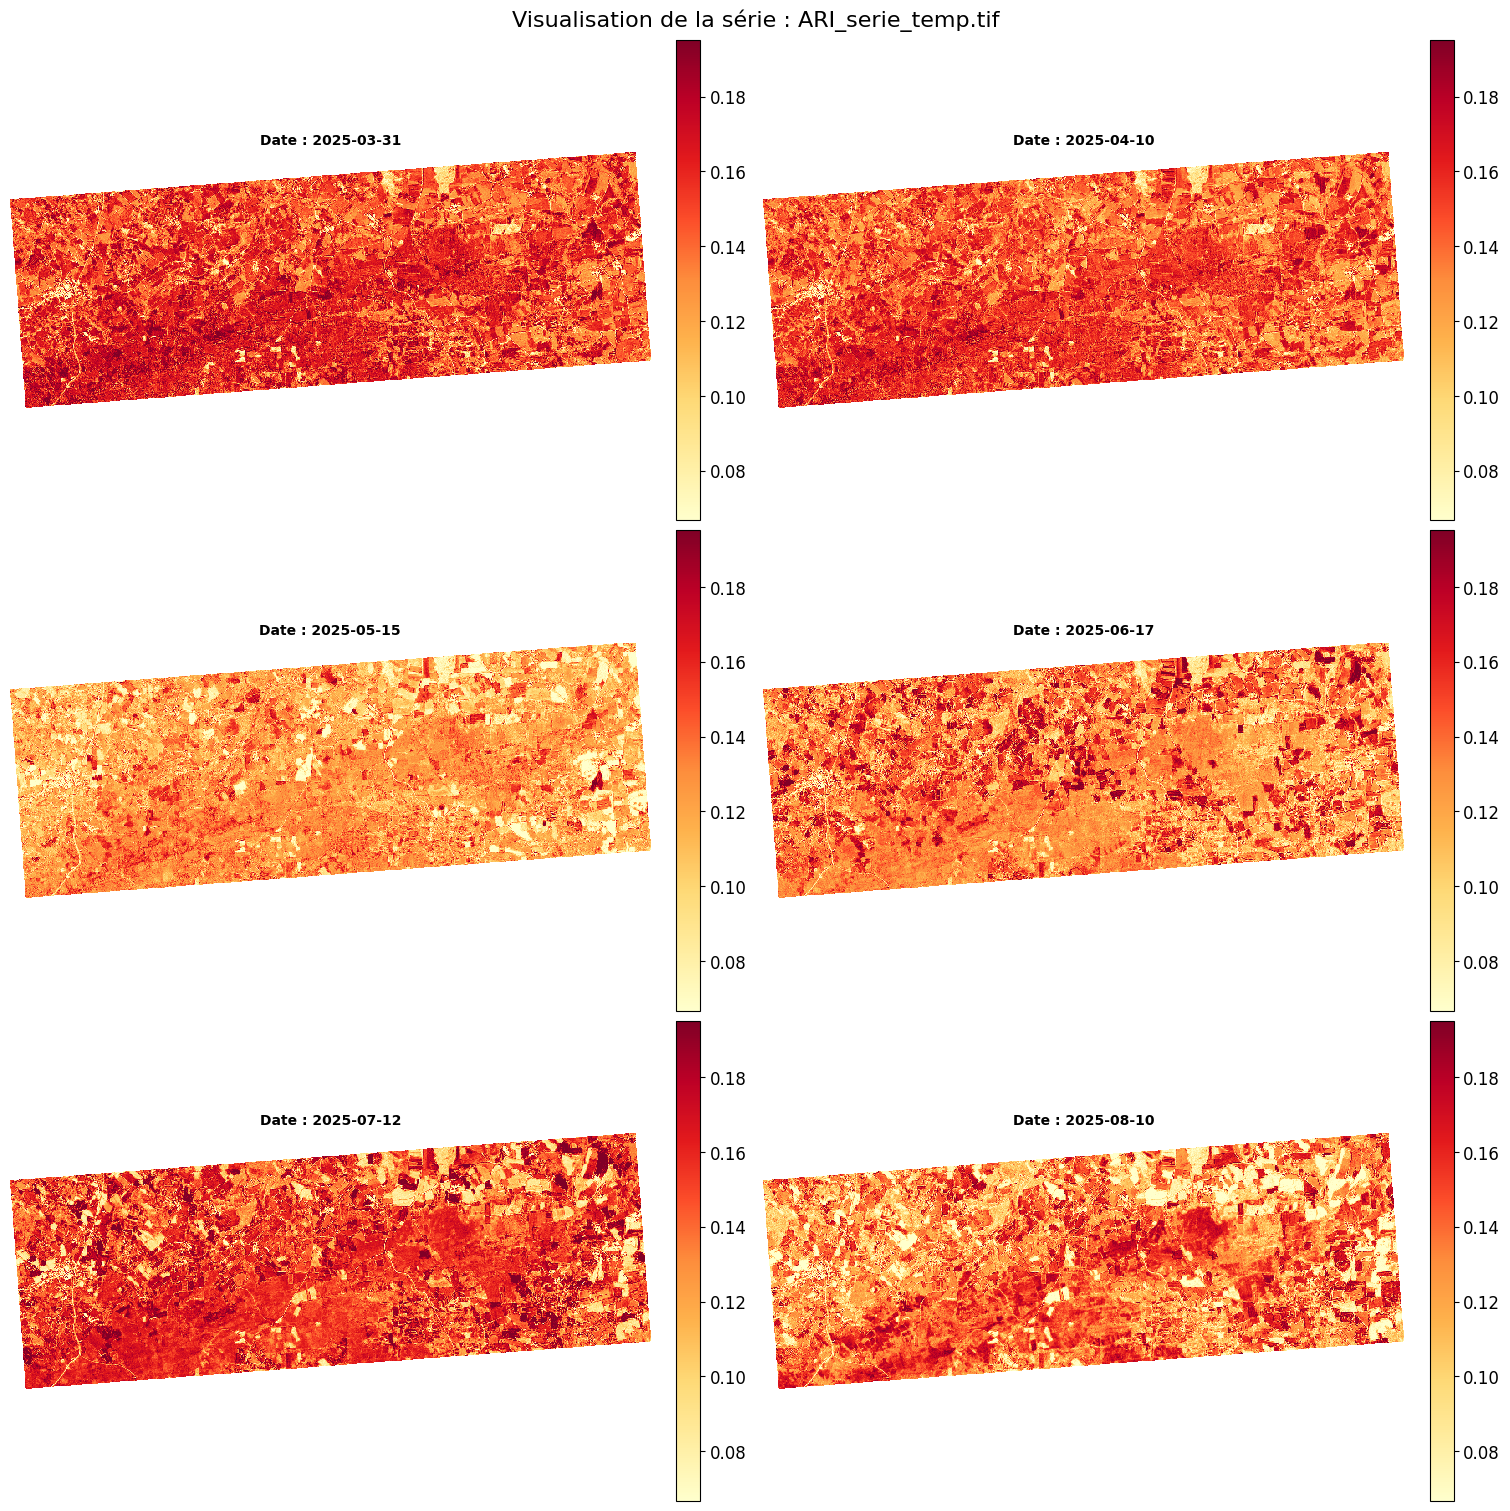

In [14]:
mf.visualize_series(
    image_path=path_output_nari, 
    dates_list=dates_str
)

La visualisation spatiale préliminaire de l'indice NARI sur les 6 dates met en évidence une **dynamique temporelle** de la végétatio. MAIS pour confirmer que ces variations correspondent bien aux signatures phénologiques de nos strates d'intérêt, nous allons maintenant agréger ces pixels et tracer les **profils temporels moyens** par classe.

### ➥ Série temporelle moyenne d’ARI de chaque strate
En effet, l'image produite juste avant contient l'information spectrale mais reste 'aveugle' quant à la nature de l'occupation du sol. L'étape suivante consiste donc à superposer les échantillons vectoriels (polygones) à la série temporelle d'ARI. Ce croisement permet d'extraire les statistiques zonales nécessaires pour établir la signature spectrale de référence pour chaque type de végétation.

    Extraction des statistiques par classe

In [15]:
# Chargement de l'image
ari_cube = rw.load_img_as_array(path_output_nari).astype('float32')
ari_cube[ari_cube == -9999] = np.nan

# Rastérisation des échantillons
mask_classes = mf.rasterize_samples(
    image_ref_path=path_output_nari, 
    vector_path=shp_path, 
    field_name='strate'
)

# Calcul des stats
stats_results = mf.extract_temporal_stats(
    ari_cube=ari_cube, 
    mask_classes=mask_classes, 
    classes_info=CLASSES_INFO
)

    Génération du graphique

=> Graphique sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


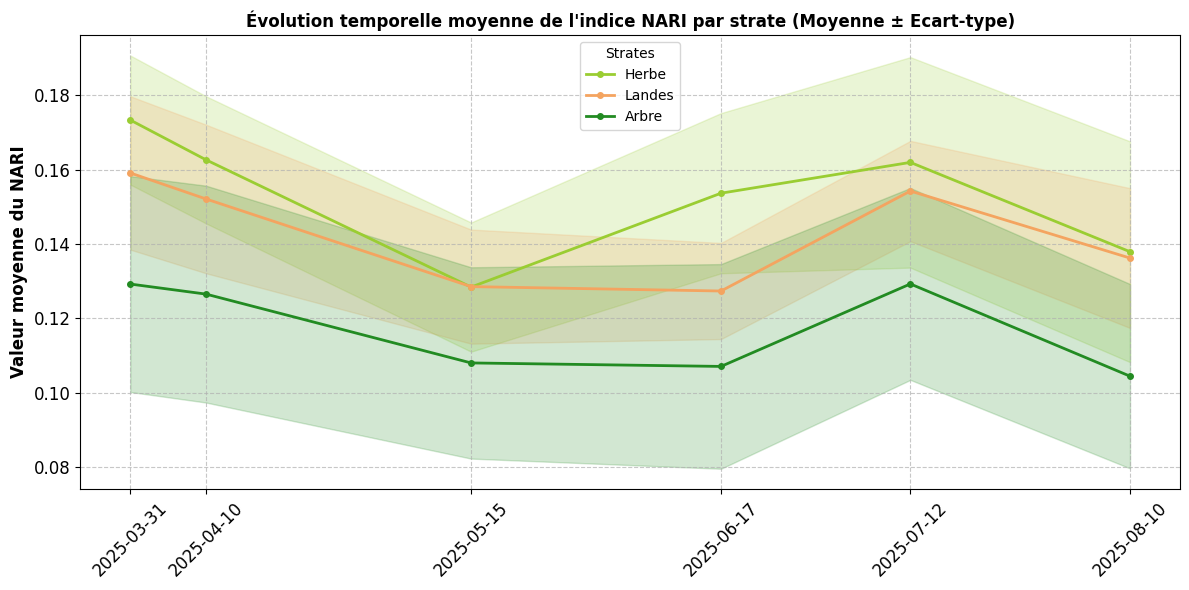

Strate Herbe : moyenne des écarts-types = 0.0219
Strate Landes : moyenne des écarts-types = 0.0168
Strate Arbre : moyenne des écarts-types = 0.0270


In [16]:
# Récupération des dates
dates = pd.to_datetime(dates_str)

# Affichage
mf.plot_nari_series(
    stats_dict=stats_results, 
    dates=dates, 
    out_filename=path_output_nari_series
)
# Aide à l'interprétation
for classe, data in stats_results.items():
    std_moyen = np.mean(data['std'])
    print(f"Strate {classe} : moyenne des écarts-types = {std_moyen:.4f}")

L'analyse de ce graphique nous informe que : 
- **Stratification constante sur la quasi-totalité de la série** : la classe `Herbe` présente systématiquement les valeurs les plus élevées, la classe `Arbre` les valeurs les plus faibles, et la classe `Landes` se situe à un niveau intermédiaire.
- **Exception notable au mois de Mai** : les courbes des classes `Herbe` et `Landes` convergent vers des valeurs similaires, rendant leur distinction difficile à cette date précise.
- **Variabilité intra-classe contrastée** : la strate `Landes` se distingue par une grande stabilité spectrale (*~ 0.017*), nettement supérieure à celle de la classe `Arbre` qui affiche la plus forte dispersion (*~ 0.027*).

---
# 3. Production d’une carte de strates à l’échelle du pixel

## 3.1. -- Préparation de la Matrice X (Features) et du Vecteur Y (Labels)

### ➥ Définition de la liste de TOUTES les images à utiliser (Features)

Pour l'entraînement du modèle, nous construisons un **jeu de données composite**. Il agrège les **bandes spectrales brutes** (information physique fondamentale sur toute la série temporelle) et l'**indice NARI** calculé précédemment. 

> *L'ajout du NARI en tant que variable supplémentaire (Feature Engineering) vise à fournir au classifieur une information "experte" pour mieux discriminer les landes, en plus de la signature spectrale classique.*

In [17]:
input_files = [
    # Bandes brutes (Séries Temporelles)
    path_B02, path_B03, path_B04, path_B05, 
    path_B08, path_B8A, path_B11,path_B12,
    # Indice ARI calculé (Feature Engineering)
    path_output_nari
]

### ➥ Formation de la matrice

Cette étape cruciale **transforme les données géospatiales en matrices exploitables par l'algorithme de Machine Learning**. La fonction effectue l'intersection spatiale entre le stack d'images (Bandes + NARI) et la vérité terrain pour générer deux jeux de données :

- **X et Y (Training Set)** : Les matrices contenant uniquement les pixels situés sous les polygones, utilisées pour l'apprentissage supervisé.
- **X_full (Inference Set)** : La matrice complète de l'image (tous les pixels de la zone), conservée en mémoire pour produire la carte de classification finale."

In [18]:
# Récupère X, Y (pour l'entrainement) ET X_full (pour la carte finale)
X, Y, X_full = mf.prepare_training_dataset(
    list_files=input_files, 
    shp_path=shp_path, 
    field_name='strate'
)

--- Préparation du Dataset d'entraînement ---
Chargement de 9 fichiers...
 -> Ajouté : bretagne_24-25_B02.tif (6 dates)
 -> Ajouté : bretagne_24-25_B03.tif (6 dates)
 -> Ajouté : bretagne_24-25_B04.tif (6 dates)
 -> Ajouté : bretagne_24-25_B05.tif (6 dates)
 -> Ajouté : bretagne_24-25_B08.tif (6 dates)
 -> Ajouté : bretagne_24-25_B8A.tif (6 dates)
 -> Ajouté : bretagne_24-25_B11.tif (6 dates)
 -> Ajouté : bretagne_24-25_B12.tif (6 dates)
 -> Ajouté : ARI_serie_temp.tif (6 dates)
Dataset, X (Tab. variables) et Y (Tab. classes) extraits.


### ➥ Affichage du bilan

In [19]:
mf.print_X_Y_matrix_bilan(X, Y, X_full)


                 BILAN DES DONNÉES D ENTRÉE                 

1. RÉALITÉ TERRAIN (X_full) -> Pour la Carte Finale
   • Structure  : CUBE 3D (Lignes, Colonnes, Variables)
   • Dimensions : (612, 1533, 54)
   • Surface    : 938 196 pixels totaux
   • Variables  : 54
------------------------------------------------------------
2. JEU D'ENTRAÎNEMENT (X, Y) -> Pour le Modèle
   • Structure  : TABLEAU 2D (Échantillons, Variables)
   • Dimensions X : (3839, 54)
   • Dimensions Y : (3839,)
   • Échantillons : 3 839 pixels annotés
------------------------------------------------------------
3. ANALYSE DU RATIO
   => Le modèle apprend sur 0.409% de la zone totale.
   => COHÉRENCE OK : 54 variables de part et d'autre.



## 3.2. -- Choix du classifieur et sa paramètrisation

### ➥ Train/Test split --> (70%)/(30%)

Le jeu de données est **subdivisé aléatoirement** en deux sous-ensembles distincts selon un **ratio de 70/30** :
- **Jeu d'entraînement (X_train & Y_train)** qui est utilisé par l'algorithme pour **apprendre les règles de décision** (construction des arbres).
- **Jeu de test (X_test & Y_test)** qui est strictement isolé durant la phase d'apprentissage. Les données serviront uniquement à l'étape suivante pour **évaluer la capacité du modèle à généraliser sur des données inconnues**.

> *L'utilisation de random_state=0 fige l'aléatoire, garantissant que la répartition des pixels reste identique à chaque exécution du notebook pour assurer la reproductibilité des résultats.*

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=0 
)

print(f" -> Données d'entraînement : {X_train.shape[0]} pixels")
print(f" -> Données de test : {X_test.shape[0]} pixels")

 -> Données d'entraînement : 2687 pixels
 -> Données de test : 1152 pixels


### ➥ Définition du modèle et de la grille

Pour cette **classification supervisée**, nous utilisons l'algorithme **Random Forest**, reconnu en télédétection pour sa robustesse face au bruit et aux données de dimension moyenne. Afin d'obtenir les **meilleures performances**, nous ne fixons pas arbitrairement les hyperparamètres. Nous définissons une **grille de recherche (param_grid)** qui permettra de tester automatiquement plusieurs combinaisons (nombre d'arbres, profondeur, critères de feuilles) pour **identifier la configuration optimale spécifique** à notre zone d'étude.

In [21]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

### ➥ Cross-validation stratifiée

Afin d'optimiser les hyperparamètres sans biaiser l'évaluation, nous implémentons une **validation croisée stratifiée (Stratified K-Fold)** avec **K=5**. Contrairement à un découpage aléatoire simple, la stratification garantit que la **proportion de chaque classe est préservée** dans chaque pli. C'est indispensable pour que le modèle soit évalué sur une distribution représentative de la réalité terrain.

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### ➥ Grille de recherche = GridSearchCV

Nous mettons en place une **évaluation multi-critères** pour savoir la **meilleure métrique** à prendre en compte parmi **deux distinctes (l'Accuracy et le F1-Score)** qui seront calculées pour chaque configuration de la grille. L'objectif est de comparer ces indicateurs pour voir **si les résultats se recoupent** : si la meilleure combinaison d'hyperparamètres est identique pour les deux métriques, cela confirmera la robustesse du modèle et l'absence de biais envers une classe spécifique.

In [23]:
# Définition des métriques à comparer
scoring_metrics = {
    'Accuracy': 'accuracy',
    'F1_Macro': 'f1_macro'
}

# Configuration du GridSearch multi-métriques
# refit='Accuracy' signifie : "Une fois le calcul fini, garde le meilleur modèle selon l'Accuracy"
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring_metrics,
    refit='Accuracy', 
    n_jobs=-1,
    verbose=2
)

# Entraînement avec recherche des meilleurs hyperparamètres (Sur le TRAIN seulement)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  11.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  20.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  20.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  20.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  20.8s
[CV] END max_depth=None, max_feat

,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 5], 'n_estimators': [50, 100, ...]}"
,scoring,"{'Accuracy': 'accuracy', 'F1_Macro': 'f1_macro'}"
,n_jobs,-1
,refit,'Accuracy'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


### ➥ Résultats de l'optimisation

In [24]:
# Récupération des résultats
results = grid.cv_results_

# On cherche le meilleur score pour chaque métrique
best_idx_acc = grid.best_index_ # L'index du gagnant pour Accuracy (grâce au refit)
best_idx_f1 = results['rank_test_F1_Macro'].argmin() # L'index du gagnant pour F1

print("=== Comparaison des Métriques ===")
print(f"Meilleure config (Accuracy) : {results['params'][best_idx_acc]}")
print(f"Score Accuracy correspondant : {results['mean_test_Accuracy'][best_idx_acc]:.4f}")
print("-" * 30)
print(f"Meilleure config (F1 Macro) : {results['params'][best_idx_f1]}")
print(f"Score F1 Macro correspondant : {results['mean_test_F1_Macro'][best_idx_f1]:.4f}")

if best_idx_acc == best_idx_f1:
    print("\nCONCLUSION : Les deux métriques s'accordent sur les mêmes hyperparamètres !")
else:
    print("\nCONCLUSION : Les métriques divergent. L'Accuracy privilégie la classe majoritaire.")

=== Comparaison des Métriques ===
Meilleure config (Accuracy) : {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
Score Accuracy correspondant : 0.9747
------------------------------
Meilleure config (F1 Macro) : {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
Score F1 Macro correspondant : 0.9755

CONCLUSION : Les deux métriques s'accordent sur les mêmes hyperparamètres !


In [25]:
# Extraction du modèle final (celui avec les meilleurs paramètres)
best_rf = grid.best_estimator_

Les **deux stratégies d'évaluation** (Accuracy et F1-Score Macro) sélectionnent **identiquement la même configuration optimale** : 
=> **'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300**
Les performances estimées par validation croisée sont très élevées : une Précision Globale de 97,47 % et un F1-Score de 97,55 %.

### ➥ Evaluation sur le test (La vérité terrain)

In [26]:
y_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f"Accuracy test : {acc_test:.4f}")

Accuracy test : 0.9653


L'application du meilleur modèle sur le jeu de test (les 30% de pixels gardés isolés dès le début) donne une précision globale de 96,53 %. Ce score est extrêmement proche de celui obtenu lors de la validation croisée (~97,5 %). **L'écart entre la phase d'optimisation et la phase de test est négligeable (< 1 %)**.

## 3.3. -- Contribution des variables (importance)

Maintenant que le modèle est optimisé et validé, il est essentiel de comprendre sa logique de décision. Nous extrayons ici l'**importance relative de chaque variable explicative** (bandes spectrales et indice NARI) à partir du modèle Random Forest final. Cet indicateur mesure la capacité de chaque variable à réduire l'hétérogénéité (impureté) dans les arbres de décision. 

L'objectif est double :
- Identifier les **dates clés** du cycle phénologique qui permettent la discrimination des strates.
- Valider l'**apport de l'indice NARI** : est-il réellement utilisé par le modèle pour distinguer les landes ?"

### ➥ Calcul de l'importance associé à chaque variable

In [27]:
df_importance = mf.compute_feature_importance(
    model=best_rf, 
    file_list=input_files, 
    dates_list=dates_str
)

Nombre de variables nommées    : 54
Nombre d'importances du modèle : 54


### ➥ Top 15 des variables explicatives

    Textuel

In [28]:
print(f"Somme des importances : {df_importance['Importance'].sum():.0f}")
print("\n=== TOP 15 VARIABLES LES PLUS IMPORTANTES ===")
display(df_importance.head(15).style.hide(axis='index'))

Somme des importances : 1

=== TOP 15 VARIABLES LES PLUS IMPORTANTES ===


Variable,Importance
bretagne_24-25_B08_2025-04-10,0.061652
bretagne_24-25_B08_2025-03-31,0.061180
bretagne_24-25_B05_2025-06-17,0.058906
bretagne_24-25_B8A_2025-03-31,0.055711
bretagne_24-25_B8A_2025-04-10,0.049983
bretagne_24-25_B03_2025-07-12,0.044298
bretagne_24-25_B03_2025-06-17,0.043844
bretagne_24-25_B05_2025-08-10,0.043746
bretagne_24-25_B03_2025-08-10,0.042725
bretagne_24-25_B02_2025-07-12,0.038046


    Graphique

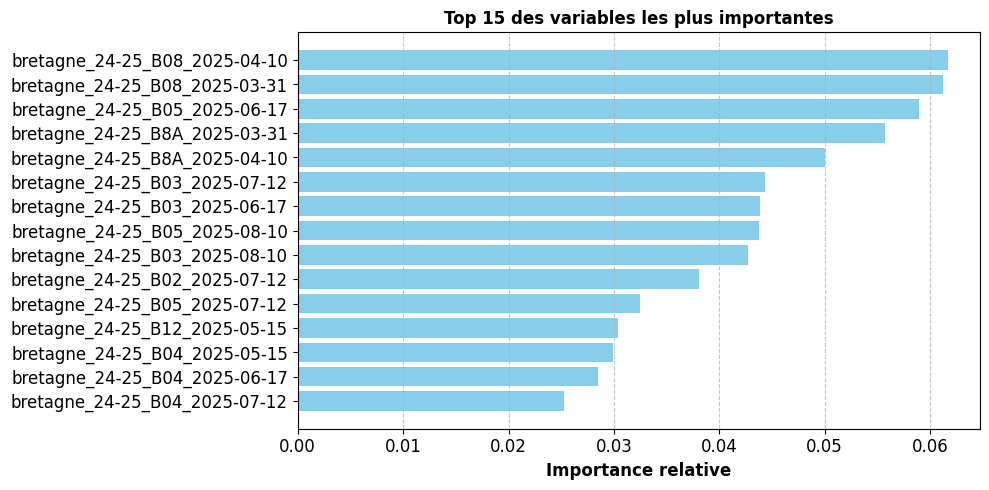

In [29]:
mf.plot_top_features(df_importance, top_n=15)

Ce graphique met en évidence une **domination nette des bandes du Proche Infrarouge (B08 et B8A) acquises au printemps (31 mars et 10 avril)**. Ces premières variables cumulent les scores d'importance les plus élevés (autour de 0,05 - 0,06). On observe ensuite une **transition saisonnière** : les variables suivantes concernent majoritairement la période estivale (juin, juillet, août) et mobilisent davantage le domaine du Visible (B02, B03, B04) et du Red-Edge (B05).

### ➥ Importance par bandes et par date - graphique

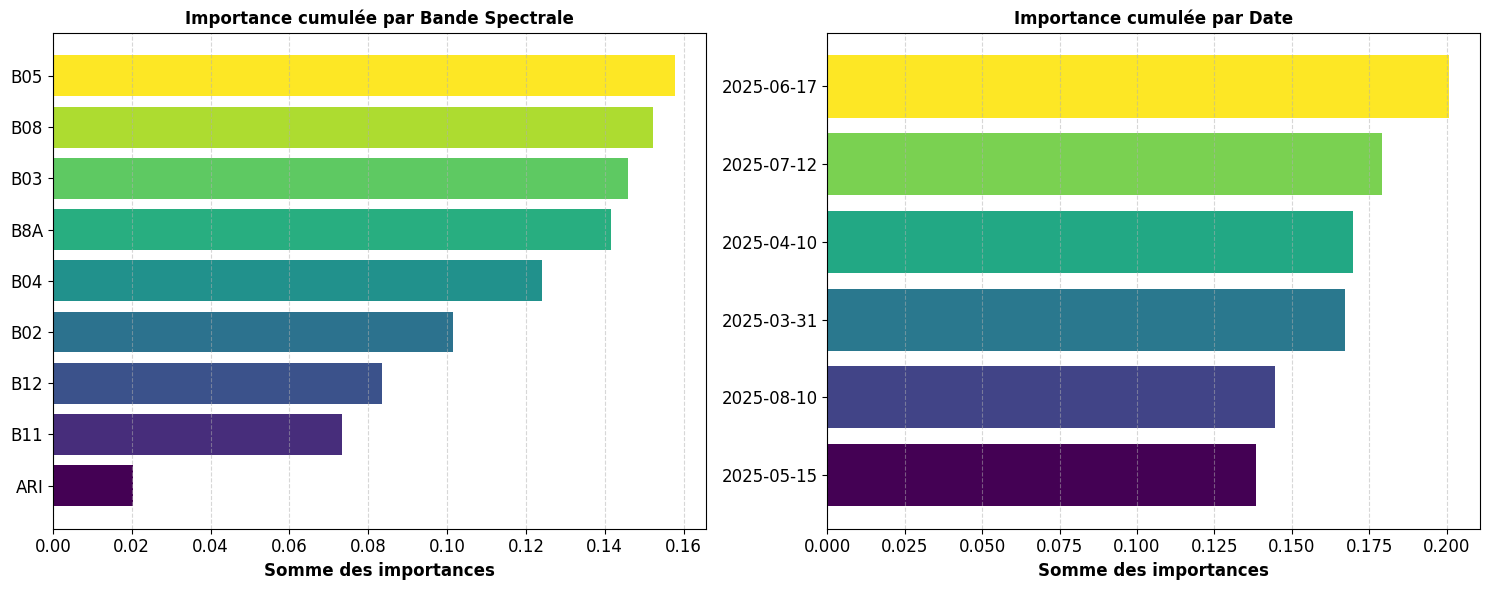

=== TOP 3 BANDES ===
Bande
B05    0.157694
B08    0.152246
B03    0.145866
Name: Importance, dtype: float64

=== TOP 3 DATES ===
Date
2025-06-17    0.200780
2025-07-12    0.179127
2025-04-10    0.169717
Name: Importance, dtype: float64


In [30]:
mf.plot_aggregated_importance(df_importance)

L'agrégation permet directement de voir que :
- Pour les **bandes** : l'information discrimante est portée prioritairement par le **Red-Edge (B05)**, suivi de près par le **Proche Infrarouge (B08)** et le **Vert (B03)**. À l'inverse, l'indice calculé **ARI** présente une contribution cumulée **négligeable** par rapport aux bandes brutes.
- Pour les **dates** : une nette **prépondérance de la période estivale** apparaît avec la date du 17 Juin étant la plus riche en information, suivie du 12 Juillet. Le mois de **Mai** (15-05) se classe en **dernière position**, contribuant le moins à la décision du modèle.

## 3.4. -- Production des cartes finales

Le modèle étant désormais entraîné, optimisé et validé, nous passons à l'étape de **généralisation**. Cette phase consiste à appliquer les règles de décision apprises par le classifieur à l'ensemble des pixels de la zone d'étude (la matrice X_full conservée en mémoire). L'objectif est de transformer nos prédictions en une **carte thématique continue de l'occupation du sol**.

### ➥ Génération de la carte

In [31]:
mf.generate_final_map(
    model=best_rf, 
    X_full=X_full,
    ref_image_path=input_files[0],
    out_path=output_map_path,
    nodata=0
)

Génération de la carte finale...
Dimensions de l'image source : (612, 1533, 54)
Dimensions : 612x1533
Pixels à prédire : 750040 (sur 938196 totaux)
Carte générée proprement : /home/onyxia/work/results/carte_strates.tif


### ➥ Affichage de la carte finale

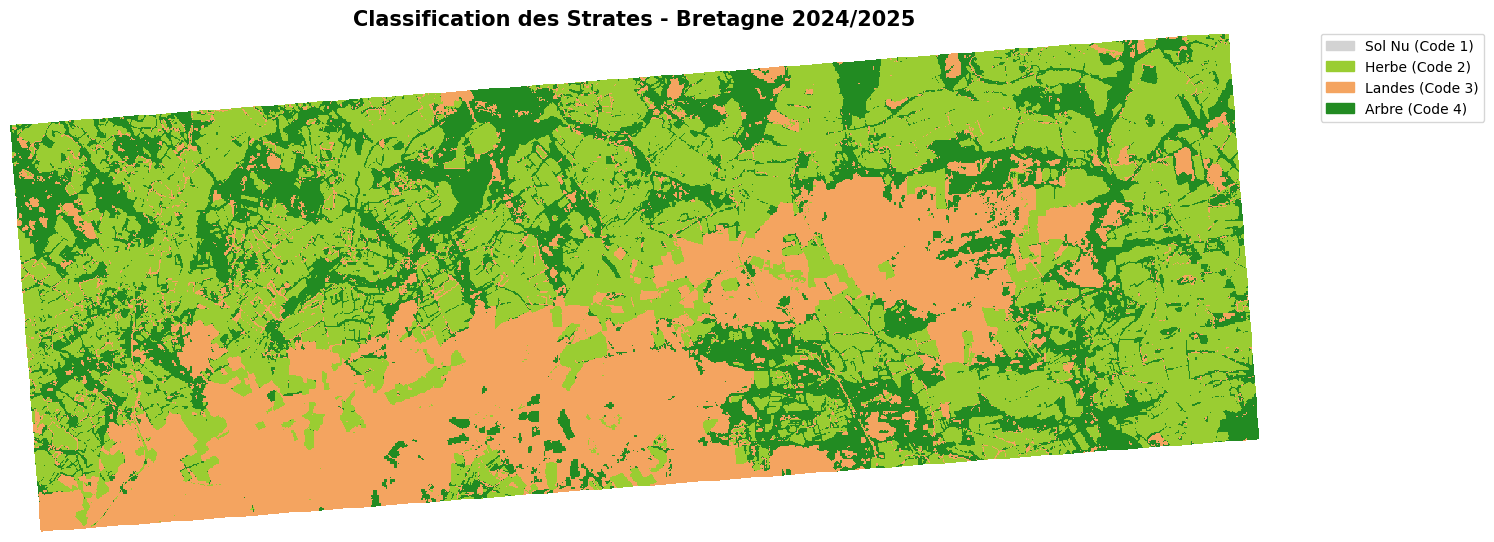

In [32]:
# Affichage de la carte finale
mf.show_classification_map(
    map_path=output_map_path, 
    classes_info=CLASSES_INFO,
    title="Classification des Strates - Bretagne 2024/2025"
)

## 3.5. -- Analyse des résultats

### ➥ Calcul des métriques nécessaires

In [33]:
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

### ➥ Graphique 1 : Matrice de Confusion

=> Figure sauvegardée dans : /home/onyxia/work/results/figure/matrice_confusion.png


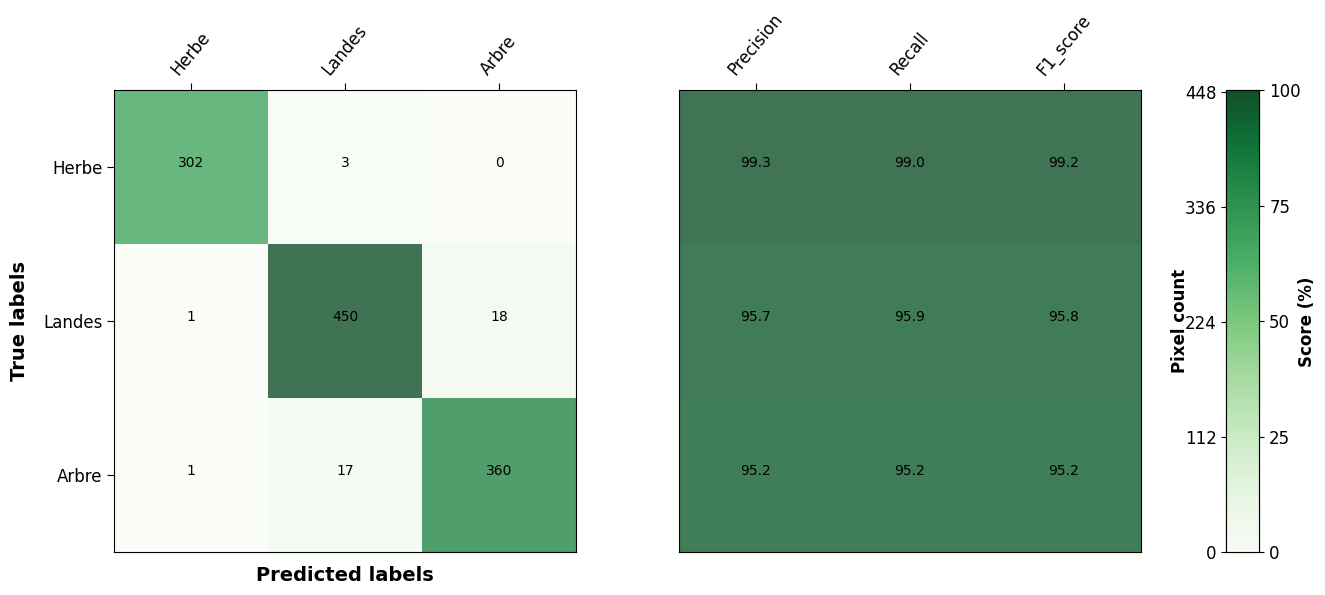

In [34]:
plots.plot_cm(
    cm=cm, 
    labels=clean_labels,
    out_filename=path_matrix,
    normalize=False
)
print(f"=> Figure sauvegardée dans : {path_matrix}")

La matrice de confusion montre une **excellente classification globale**, avec la grande majorité des pixels situés **sur la diagonale**.
- La **classe `Herbe` est la classe la mieux détectée**, avec un F1-Score de 99,2 %, il n'y a quasiment aucune confusion (seulement 3 pixels classés en `Landes` sur 305).
- Le **couple `Landes` / `Arbre`** a des performances restent très élevées (~ 95-96 %), mais on observe une **légère confusion**. MAIS le **chassé-croisé est presque parfaitement symétrique** avec 18 pixels de `Landes` ont été prédits comme `Arbre` et 17 pixels d'`Arbre` ont été prédits comme `Landes`

### ➥ Graphique 2 : Qualité par Classe (Bâtons)

=> Figure sauvegardée dans : /home/onyxia/work/results/figure/qualite_by_class.png


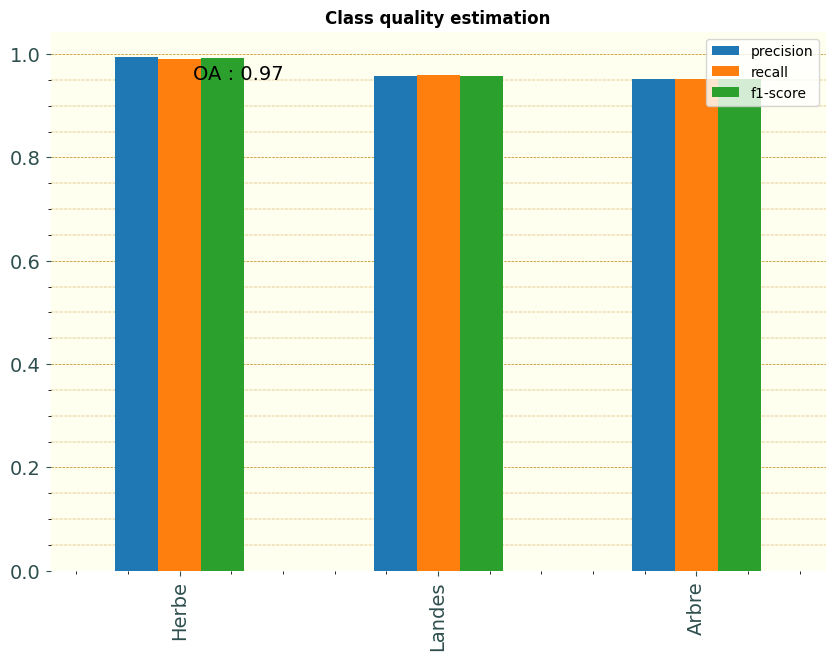

In [35]:
# Sous forme de DICTIONNAIRE pour que la fonction puisse le lire
report = classification_report(y_test, y_pred, target_names=clean_labels, 
output_dict=True)
plots.plot_class_quality(
    report=report, 
    accuracy=accuracy, 
    out_filename=path_quality
)
print(f"=> Figure sauvegardée dans : {path_quality}")

Ce graphe **confirme bien les observations de la matrice de confusion** à savoir une précision Globale de 97 % synonyme d'un modèle très performant notamment avec la classe `Herbe` mais aussi les classes ligneuses (Landes et Arbres) même si un peu en dessous. L'**alignement presque parfait des barres Précision & Rappel** indique une **absence quasi-totale de biais**.

---
# 4. Discussion

"*La **lande** est caractéristique d’une **végétation transitoire entre la forêt et la pelouse** : bruyères, petits buissons, graminées, mousses, lichens ...*"

> *https://www.biodiversite-centrevaldeloire.fr/decouvrir/la-biodiversite-en-centre-val-de-loire/grands-milieux-et-especes-associees/milieux-ouverts/landes-et-pelouses*

## 4.1. Qualité des Données et Pertinence de l'Approche

    Représentativité
L'**équilibre des classes est satisfaisant**, ce qui est crucial pour l'apprentissage supervisé. Le volume de données, bien que modeste à l'échelle d'une image satellite complète, s'est avéré suffisant pour entraîner un Random Forest robuste.

    Géométrie des échantillons
La **différence de taille des polygones reflète la réalité paysagère** : les zones boisées (`Arbre`) forment de grands massifs homogènes, tandis que l'`Herbe` est souvent plus fragmentée.

    Validation de l'hypothèse spectrale (NARI)
L'analyse des courbes NARI a confirmé que les `Landes` occupent une niche spectrale distincte. La faible valeur de l'écart-type pour la classe `Landes` témoigne d'une grande pureté spectrale des échantillons, contrairement à la classe `Arbre` (affectée par les ombres) ou `Herbe` (densités variables). Cela a grandement facilité la définition des frontières de décision.

## 4.2. Performance et Robustesse du Modèle

    Convergence des métriques
L'alignement parfait entre l'Accuracy et le F1-Score (tous deux > 97%) prouve que le modèle **traite aussi bien les classes majoritaires que minoritaires**.

    Paramétrage
Le choix de n_estimators=300 indique un besoin de **réduire la variance** (stabiliser la décision), tandis que max_depth=None suggère que la complexité des signatures spectrales nécessitait des **arbres profonds pour capter les nuances fines**.

    Généralisation (Absence de sur-apprentissage)
Le fait que le score sur le jeu de test (96,6 %) soit quasi-identique à celui de l'entraînement est le résultat le plus important. Il dit que le modèle a extrait des règles phénologiques universelles et non appris par cœur les données. 

On peut cependant émettre  l'hypothèse que ce score soit potentiellement influencé par l'**autocorrelation spatiale** (= pixels voisins). En effet, si des pixels d'un même polygone sont à la fois dans le train et le test, le modèle ne généralise pas, il reconnaît juste la parcelle qu'il a déjà vue en partie. Il serait intéressant alors de ne pas split par pixel mais plutôt par polygone et ainsi garantir qu'aucun pixel d'un polygone de test n'a été "vu" pendant l'entraînement.

## 4.3. Les Moteurs de la Classification

    Le rôle pivot du Red-Edge et du NIR 
La dominance de la bande B05 (Red-Edge) confirme que la distinction se joue sur la **structure cellulaire et la transition chlorophyllienne**, plus que sur la couleur visible.

    La Stratégie Temporelle (Le "Chassé-Croisé")
Le Printemps (Mars/Avril) =>  C'est le moment critique pour **distinguer la structure (via le NIR/B08) entre les landes persistantes et les feuillus/herbacées** en démarrage de cycle.
L'Été (Juin) => Globalement, c'est la période la plus informative pour évaluer la **vigueur (chlorophylle)** et séparer l'herbe jaunissante des ligneux.

    L'Intelligence du Modèle (Gestion du Bruit) 
Le modèle a attribué une importance très faible au mois de Mai. Cela valide l'observation initiale du croisement des courbes spectrales (point de confusion). L'algorithme **a "appris" à ignorer cette date ambiguë** pour se concentrer sur les périodes de contraste maximal.

## 4.4. Analyse des Erreurs et Limites

    La Facilité de l'Herbe
La classe `Herbe` obtient des scores quasi-parfaits (F1 ~99%), s'expliquant par une **signature radicalement différente** (absence d'ombre, cycle de fauche) des strates ligneuses.

    L'Écotone Lande-Forêt
Les seules erreurs notables (4-5 %) concernent la **confusion réciproque entre `Landes` et `Arbre`**.
==> Explication Physique
On à affaire à des **effets de lisière** (pixels mixtes contenant branches et buissons) ou à une **similarité structurelle** entre des landes hautes (ajoncs denses) et de jeunes arbres.
==> Contrainte Spectrale 
L'importance de l'indice NARI s'est révélée décevante dans le modèle. L'**absence d'images automnales** (due à une couverture nuageuse persistante sur la Bretagne) a empêché de capturer le pic de réflectance des anthocyanes, forçant le modèle à se baser sur le Red-Edge pour discriminer ces deux classes.

    L'Angle Mort du "Sol Nu" 
Une limite majeure de la classification réside dans l'**absence de la classe `Sol Nu`** dans le jeu d'apprentissage (aussi le cas pour le bâti). Aucun polygone n'ayant été identifié pour cette occupation, le modèle est incapable de la prédire. 

![erreurs_sol_nu](/home/onyxia/work/projet_telea_IBRES/img/erreurs_sol_nu.png)

Les surfaces minérales réelles (chemins, zones érodées), comme sur l'image ci-dessus, sont donc **absorbées par les classes végétales les plus proches spectralement**, créant un **biais invisible** dans les métriques de performance. On a une surestimation du nombre de pixel pour les strates.

    Bilan Opérationnel 
Malgré ces limites, l'absence de biais majeur (Précision $\approx$ Rappel) rend la carte finale directement exploitable pour des statistiques territoriales de suivi des milieux naturels. Elle doit cependant être interprétée comme **une carte des couvertures végétales dominantes plutôt que comme une occupation du sol exhaustive** (cf. biais de l'absence du `Sol Nu`).

---